In [14]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

subject_id = 2

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [15]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, 
                      #eeg_data_2,
                      eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, 
                          #gradcpt_data_2,
                          gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


### z-normalization

In [16]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [17]:
from scipy.signal import iirnotch, filtfilt
for channel in channels:
    fs = 256
    f0 = 50
    quality_factor = 30
    
    b, a = iirnotch(f0, quality_factor, fs)
    eeg_data.loc[:, f'{channel}_filt'] = filtfilt(b, a, eeg_data[f'{channel}_normal'])
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_filt']) 

### Bandpass

In [18]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

### Normalization

In [19]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Separate trials

In [20]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

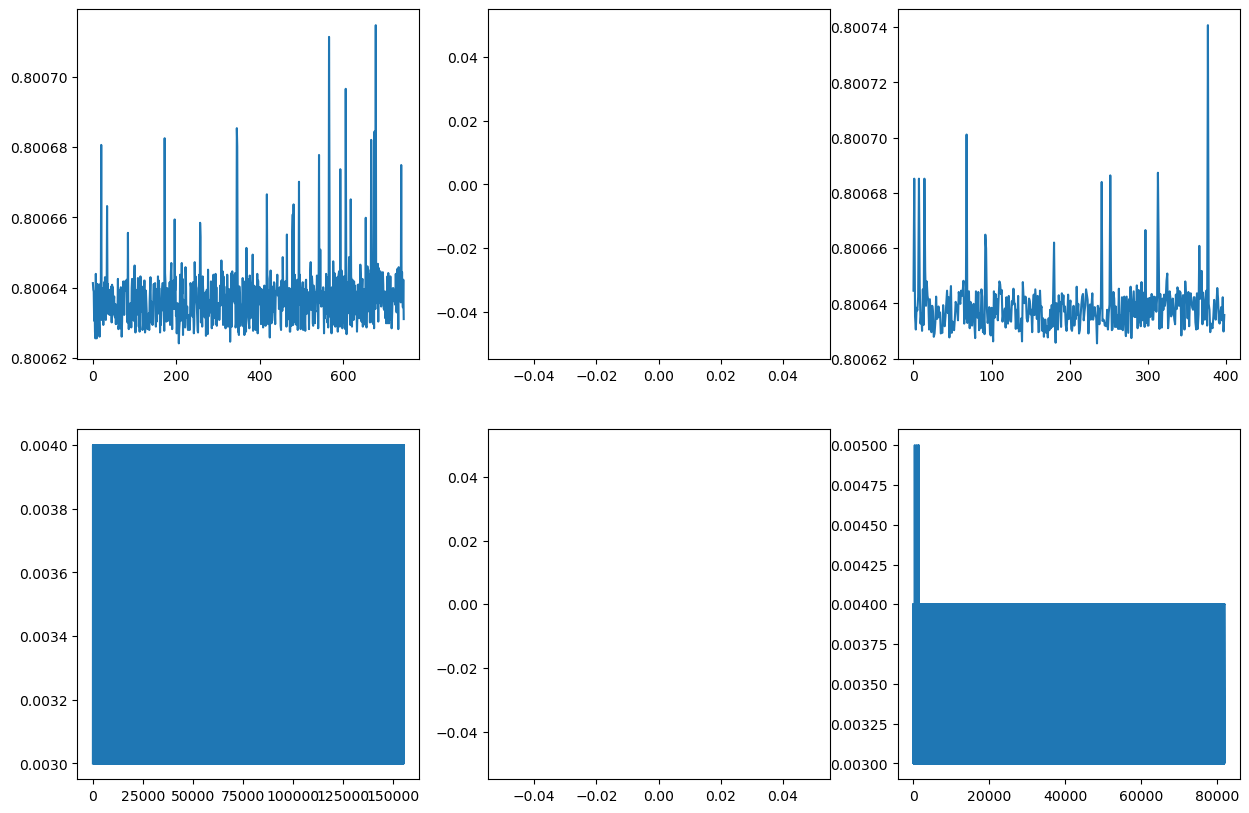

In [21]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

/home/henri/miniconda3/envs/training-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/henri/miniconda3/envs/training-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


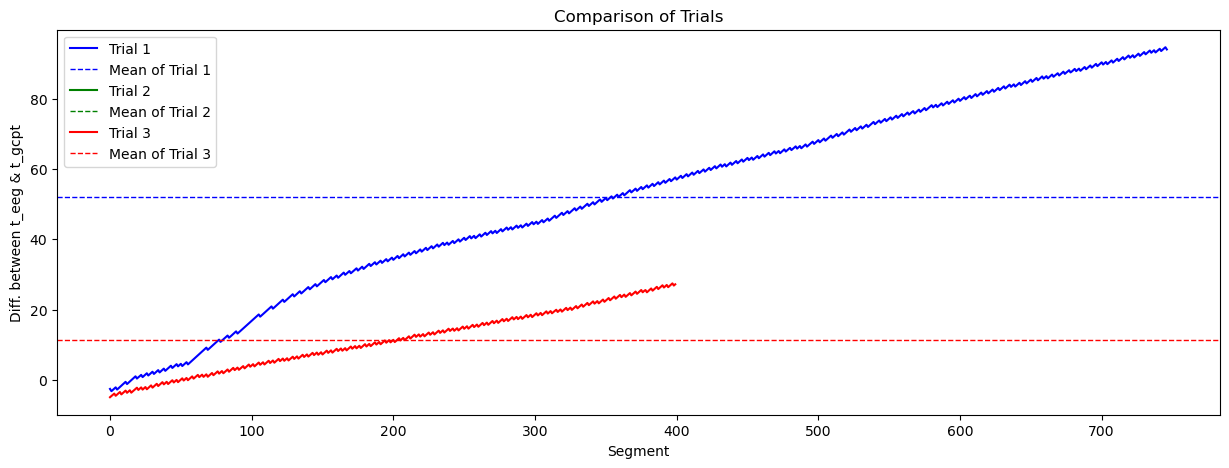

In [22]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Extract features

In [23]:
import numpy as np
from scipy.signal import coherence, welch

def calculate_coherence(signal1, signal2, fs=256):
    f, Cxy = coherence(signal1, signal2, fs=fs, nperseg=256)
    return f, Cxy

def cross_correlation(signal1, signal2, max_lag=10):
    corr = np.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    lags = np.arange(-len(signal1) + 1, len(signal1))
    max_corr = np.max(corr)
    lag_at_max = lags[np.argmax(corr)]
    return max_corr, lag_at_max

def phase_locking_value(signal1, signal2):
    phase_diff = np.angle(signal1) - np.angle(signal2)
    PLV = np.abs(np.sum(np.exp(1j * phase_diff)) / len(phase_diff))
    return PLV

from sklearn.metrics import mutual_info_score

def mutual_information(signal1, signal2, num_bins=64):
    hist_2d, x_edges, y_edges = np.histogram2d(signal1, signal2, bins=num_bins)
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    mi = mutual_info_score(None, None, contingency=pxy)
    return mi

from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality(signal1, signal2, maxlag=2):
    data = np.column_stack([signal1, signal2])
    result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1)]
    return np.min(p_values)


In [24]:
def extract_pairwise_features(segments_dict):
    channels = list(segments_dict.keys())
    features_data = []

    # Iterating over all unique pairs of channel-band combinations
    for i in range(len(channels)):
        for j in range(i + 1, len(channels)):
            # Extract channel and band names
            ch1, band1 = channels[i].split('_')
            ch2, band2 = channels[j].split('_')
            signal1 = segments_dict[channels[i]]
            signal2 = segments_dict[channels[j]]

            # Calculate pairwise features
            mean_coherence = calculate_coherence(signal1, signal2)

            # Store features in a dictionary
            feature_key = f'{ch1}_{band1}_vs_{ch2}_{band2}_coherence'
            features_data.append({feature_key: mean_coherence})

    return pd.DataFrame(features_data)

In [29]:
def process_all_trials(eeg_data, gradcpt_data, channels):
    features_dfs = []

    for trial in [1, 3]:
        cur_eeg_df = eeg_data[trial]
        cur_gcpt_df = gradcpt_data[trial]
        
        all_segments = {}

        # Process each channel and decompose into frequency bands
        for channel in channels:
            segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
            print(f"Number of segments for {channel}: {len(segments)}")  # Debug print
            
            segment_bands = [decompose_segment(segment) for segment in segments]
            print(f"Decomposition completed for {channel}")  # Debug print

            # Store each band's data in a dictionary for pairwise comparisons
            for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
                if any(seg[band] is None for seg in segment_bands):
                    print(f"Missing data in {band} for channel {channel}")  # Debug print

                band_data = [seg[band] for seg in segment_bands if seg[band] is not None]
                if band_data:
                    all_segments[f'{channel}_{band}'] = np.concatenate(band_data)
                else:
                    print(f"No data to concatenate for {channel}_{band}")  # Debug print

        # Extract pairwise features from the decomposed segments
        features_df = extract_pairwise_features(all_segments)
        features_df['in_the_zone'] = cur_gcpt_df['in_the_zone'].values[0]  # Adjust depending on how you segment 'in_the_zone'
        features_dfs.append(features_df)
        
        print(f'Trial {trial} done.')

    return features_dfs


eeg_data = {1: eeg_data_t1,  3: eeg_data_t3}
gradcpt_data = {1: gradcpt_data_t1, 3: gradcpt_data_t3}
channels = ['AF7', 'AF8', 'TP9', 'TP10']

features_dfs = process_all_trials(eeg_data, gradcpt_data, channels)


Number of segments for AF7: 747
Decomposition completed for AF7
Number of segments for AF8: 747
Decomposition completed for AF8
Number of segments for TP9: 747
Decomposition completed for TP9
Number of segments for TP10: 747
Decomposition completed for TP10
Trial 1 done.
Number of segments for AF7: 400
Decomposition completed for AF7
Number of segments for AF8: 400
Decomposition completed for AF8
Number of segments for TP9: 400
Decomposition completed for TP9
Number of segments for TP10: 400
Decomposition completed for TP10
Trial 3 done.


In [15]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

In [31]:
features_dfs

[                      AF7_delta_vs_AF7_theta_coherence  \
 0    ([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   
 1                                                  NaN   
 2                                                  NaN   
 3                                                  NaN   
 4                                                  NaN   
 ..                                                 ...   
 185                                                NaN   
 186                                                NaN   
 187                                                NaN   
 188                                                NaN   
 189                                                NaN   
 
                       AF7_delta_vs_AF7_alpha_coherence  \
 0                                                  NaN   
 1    ([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...   
 2                                                  NaN   
 3                                                  Na

## Detach rocket

### Train and eval

In [ ]:
from detach_rocket.detach_rocket.detach_classes import DetachMatrix
from sklearn.model_selection import train_test_split

X = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

detach_matrix = DetachMatrix(trade_off=0.1)
detach_matrix.fit(X_train, y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= detach_matrix.score(X_test, y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

### Plot SFD Curve and Optimal Model selection

In [ ]:
import matplotlib.pyplot as plt
percentage_vector = detach_matrix._percentage_vector
acc_curve = detach_matrix._sfd_curve

c = detach_matrix.trade_off

x_sfd=(percentage_vector) * 100
y_sfd=(acc_curve/acc_curve[0]-1) * 100

point_x = x_sfd[detach_matrix._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x_sfd, y_sfd, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### Keep the optimal features

In [ ]:
if hasattr(detach_matrix, '_feature_mask'):
    feature_mask = detach_matrix._feature_mask
    
    selected_features_df = X.loc[:, feature_mask]
    selected_features_df = selected_features_df.assign(Label=y)
else:
    print("Feature mask not found in DetachMatrix object.")

### Train the model

In [16]:
for feats in [1, 10, 25, 50, 75, 100, 250]:
    print(train(runs=2, num_features=feats, df=combined_features_df))

{'train_acc': 0.5694842997964296, 'test_acc': 0.5468255768732175, 'f1_score': 0.5077610999364505}
{'train_acc': 0.5956911120343665, 'test_acc': 0.5363565162907268, 'f1_score': 0.48979030230239184}
{'train_acc': 0.6377985460894612, 'test_acc': 0.5243507475585515, 'f1_score': 0.4805415302694014}
{'train_acc': 0.6901582817755465, 'test_acc': 0.5539435874168179, 'f1_score': 0.5279677330000909}
{'train_acc': 0.7243451114175417, 'test_acc': 0.5543017025321925, 'f1_score': 0.5410517987085418}
{'train_acc': 0.7282195016540542, 'test_acc': 0.5548839771843401, 'f1_score': 0.5362541293756846}
{'train_acc': 0.7609900482361873, 'test_acc': 0.570132767262985, 'f1_score': 0.5643535867691385}


In [17]:
X = combined_features_df.iloc[:, :-1].values
y = combined_features_df.iloc[:, -1].values

num_features = 250

def select_top_features_welch(X, y, num_features=num_features):
    _, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0, equal_var=False)
    top_features_indices = np.argsort(p_values)[:num_features]
    return top_features_indices, p_values[top_features_indices]

# Using Welch's t-test
top_features_indices_welch, p_values_welch = select_top_features_welch(X, y, num_features)
print("Top features using Welch's t-test:")
for i, idx in enumerate(top_features_indices_welch):
    column_name = combined_features_df.columns[idx]
    t_statistic, _ = ttest_ind(X[y == 0, idx], X[y == 1, idx], equal_var=False)
    print(f"Feature {i+1}: {column_name}, p-value: {p_values_welch[i]}, t-statistic: {t_statistic}")


Top features using Welch's t-test:
Feature 1: AF7_alpha_hjorth_activity_win0, p-value: 5.219318423995454e-07, t-statistic: -5.0471964797404025
Feature 2: AF7_alpha_energy_win0, p-value: 5.229100517113277e-07, t-statistic: -5.046830467378757
Feature 3: AF7_alpha_standard_deviation_win0, p-value: 1.0616680223384824e-06, t-statistic: -4.9066154541388585
Feature 4: AF7_alpha_total_variation_win0, p-value: 1.3126823426003114e-06, t-statistic: -4.863881068448517
Feature 5: AF8_gamma_spectral_entropy_win-9, p-value: 1.3162227061111318e-06, t-statistic: -4.867807115180713
Feature 6: AF7_alpha_standard_deviation_win-7, p-value: 1.8934771405023401e-06, t-statistic: -4.789263915816425
Feature 7: AF7_alpha_standard_deviation_win-8, p-value: 1.9408172833916047e-06, t-statistic: -4.784197055799002
Feature 8: AF7_alpha_hjorth_activity_win-1, p-value: 2.035025848006878e-06, t-statistic: -4.774651188652983
Feature 9: AF7_alpha_energy_win-1, p-value: 2.0387575805256662e-06, t-statistic: -4.7742750418671